# ML draft

Method and code is adopted from https://github.com/morrismanfung/yukoproject2022/blob/main/02-model/001-knn.ipynb

## General Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
data_full = pd.read_csv( 'data/risk_factors_cervical_cancer.csv')

In [3]:
data_full.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
data_full[ 'target'] = data_full[ 'Hinselmann'] | data_full[ 'Schiller'] | data_full[ 'Citology'] | data_full[ 'Biopsy']
data_full = data_full.replace('?', np.nan)

In [5]:
data_full[ 'target'].value_counts()

0    756
1    102
Name: target, dtype: int64

In [6]:
STDs = ['STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV']

for i in STDs:
    print( i)
    print( data_full[ i].value_counts())
    print()

STDs:condylomatosis
0.0    709
1.0     44
Name: STDs:condylomatosis, dtype: int64

STDs:cervical condylomatosis
0.0    753
Name: STDs:cervical condylomatosis, dtype: int64

STDs:vaginal condylomatosis
0.0    749
1.0      4
Name: STDs:vaginal condylomatosis, dtype: int64

STDs:vulvo-perineal condylomatosis
0.0    710
1.0     43
Name: STDs:vulvo-perineal condylomatosis, dtype: int64

STDs:syphilis
0.0    735
1.0     18
Name: STDs:syphilis, dtype: int64

STDs:pelvic inflammatory disease
0.0    752
1.0      1
Name: STDs:pelvic inflammatory disease, dtype: int64

STDs:genital herpes
0.0    752
1.0      1
Name: STDs:genital herpes, dtype: int64

STDs:molluscum contagiosum
0.0    752
1.0      1
Name: STDs:molluscum contagiosum, dtype: int64

STDs:AIDS
0.0    753
Name: STDs:AIDS, dtype: int64

STDs:HIV
0.0    735
1.0     18
Name: STDs:HIV, dtype: int64



In [7]:
Dxs = ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']
for i in Dxs:
    print( i)
    print( data_full[ i].value_counts())
    print()

Dx:Cancer
0    840
1     18
Name: Dx:Cancer, dtype: int64

Dx:CIN
0    849
1      9
Name: Dx:CIN, dtype: int64

Dx:HPV
0    840
1     18
Name: Dx:HPV, dtype: int64

Dx
0    834
1     24
Name: Dx, dtype: int64



In [8]:
numeric_features = [ 'Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs (number)']

binary_features = [ 'STDs:condylomatosis', 'Smokes', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Hinselmann']

columns_tbc = numeric_features+binary_features

column_transformer = make_column_transformer(
    ( make_pipeline( SimpleImputer( strategy = 'median'), StandardScaler()), numeric_features),
    ( make_pipeline( SimpleImputer( strategy = 'constant', fill_value = '99'), OneHotEncoder( handle_unknown = 'ignore')), binary_features)
)

In [9]:
X = data_full[ columns_tbc]
y = data_full[ 'target']

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.5, stratify = y, random_state = 123)

## KNN

In [11]:
result_dict = {}
scoring_metrics = [ 'precision', 'recall', 'f1']

In [12]:
pipe_knn = make_pipeline( column_transformer, KNeighborsClassifier()) # No class weight in KNN

cv_result = cross_validate( pipe_knn, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'KNN'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'KNN']

,mean,std
fit_time,0.013790,0.004319
score_time,0.052255,0.071590
test_precision,0.340000,0.421900
train_precision,0.706984,0.150416
test_recall,0.058182,0.053242
train_recall,0.171463,0.072884
test_f1,0.093800,0.087339
train_f1,0.272490,0.097502


In [13]:
param_grid = {
    "kneighborsclassifier__n_neighbors": list( range( 5, 35, 5))
}

grid_search = GridSearchCV(
    pipe_knn, param_grid, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame( grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False)

,params,mean_test_score
0,{'kneighborsclassifier__n_neighbors': 5},0.058182
1,{'kneighborsclassifier__n_neighbors': 10},0.000000
2,{'kneighborsclassifier__n_neighbors': 15},0.000000
3,{'kneighborsclassifier__n_neighbors': 20},0.000000
4,{'kneighborsclassifier__n_neighbors': 25},0.000000
5,{'kneighborsclassifier__n_neighbors': 30},0.000000


In [14]:
pipe_knn_opt = make_pipeline( column_transformer, KNeighborsClassifier( n_neighbors = 5)) # No class weight in KNN

cv_result = cross_validate( pipe_knn_opt, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'KNN_opt'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'KNN_opt']

,mean,std
fit_time,0.017916,0.007627
score_time,0.017277,0.005906
test_precision,0.340000,0.421900
train_precision,0.706984,0.150416
test_recall,0.058182,0.053242
train_recall,0.171463,0.072884
test_f1,0.093800,0.087339
train_f1,0.272490,0.097502


In [15]:
y_hat = grid_search.predict( X_test)

In [16]:
def better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]):
    df = pd.DataFrame( confusion_matrix( y_test, y_hat, labels = labels))
    df.columns = labels
    df = pd.concat( [ df], axis = 1, keys = ['Predicted'])
    df.index = labels
    df = pd.concat( [df], axis = 0, keys = ['Actual'])
    return df

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [18]:
def better_metrics( y_test, y_hat):
    precision = precision_score( y_test, y_hat)
    recall = recall_score( y_test, y_hat)
    f1 = f1_score( y_test, y_hat)
    auc = roc_auc_score( y_test, y_hat)
    metrics_dict = {
        'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}
    return metrics_dict

In [19]:
test_results = {}
test_results[ 'KNN_opt'] = better_metrics( y_test, y_hat)

In [20]:
print( better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print()
print( classification_report( y_test, y_hat))

         Predicted   
                 0  1
Actual 0       373  5
       1        43  8

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       378
           1       0.62      0.16      0.25        51

    accuracy                           0.89       429
   macro avg       0.76      0.57      0.59       429
weighted avg       0.86      0.89      0.86       429



## SVC

In [21]:
pipe_svc = make_pipeline( column_transformer, SVC( class_weight = 'balanced'))
cv_result = cross_validate( pipe_svc, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'SVC'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'SVC']

,mean,std
fit_time,0.010615,0.008644
score_time,0.013466,0.003457
test_precision,0.379286,0.086058
train_precision,0.600542,0.148967
test_recall,0.527273,0.196771
train_recall,0.779268,0.046518
test_f1,0.436559,0.115877
train_f1,0.669204,0.086089


In [22]:
param_dist = {
    'svc__C': [ 10**x for x in range( -2, 5)],
    'svc__gamma': [ 10**x for x in range( -2, 5)]
}

random_search = RandomizedSearchCV(
    pipe_svc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True
)

random_search.fit( X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Number '
                                                                                'of '
                                                                                'sexual '
                                                                                'partners',
                                                                                'First '
                                                                                'sexual '
                                                                                'intercourse',
                                                                                'Num '
                                                                                'of '
                                                                                'pregnancies',
                                                                                'Hormonal '
                                                                                'Contraceptives '
                                                                                '(years)',
                                                                                'I...
                                                                                                              strategy='constant')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['STDs:condylomatosis',
                                                                                'Smokes',
                                                                                'Dx:Cancer',
                                                                                'Dx:CIN',
                                                                                'Dx:HPV',
                                                                                'Hinselmann'])])),
                                             ('svc',
                                              SVC(class_weight='balanced'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100, 1000,
                                                   10000],
                                        'svc__gamma': [0.01, 0.1, 1, 10, 100,
                                                       1000, 10000]},
                   return_train_score=True, scoring='recall')

In [23]:
results = pd.DataFrame( random_search.cv_results_)
results[ ['params', 'mean_test_score', 'mean_train_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score,mean_train_score
27,"{'svc__gamma': 1, 'svc__C': 0.1}",0.900000,0.936341
11,"{'svc__gamma': 0.01, 'svc__C': 1}",0.565455,0.617317
3,"{'svc__gamma': 0.01, 'svc__C': 10}",0.565455,0.745000
16,"{'svc__gamma': 0.1, 'svc__C': 0.1}",0.550909,0.676098
26,"{'svc__gamma': 0.01, 'svc__C': 1000}",0.450909,0.911829


In [24]:
pipe_svc_opt = make_pipeline( column_transformer, SVC( gamma = 1, C = 0.1, class_weight = 'balanced'))

cv_result = cross_validate( pipe_svc_opt, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'SVC_opt'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'SVC_opt']

,mean,std
fit_time,0.022798,0.004392
score_time,0.014411,0.002620
test_precision,0.162378,0.028493
train_precision,0.181736,0.005795
test_recall,0.900000,0.100000
train_recall,0.936341,0.013032
test_f1,0.274952,0.045373
train_f1,0.304340,0.007832


In [25]:
y_hat = random_search.predict( X_test)
test_results[ 'SVC_opt'] = better_metrics( y_test, y_hat)
print( better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print()
print( classification_report( y_test, y_hat))

         Predicted     
                 0    1
Actual 0       130  248
       1        10   41

              precision    recall  f1-score   support

           0       0.93      0.34      0.50       378
           1       0.14      0.80      0.24        51

    accuracy                           0.40       429
   macro avg       0.54      0.57      0.37       429
weighted avg       0.84      0.40      0.47       429



In [26]:
def pr_curve( precision, recall):
    plot_df = pd.DataFrame( {
        'precision': precision,
        'recall': recall
    })

    chart = alt.Chart( plot_df).mark_line().encode(
        x = 'precision',
        y = 'recall'
    ).properties( height = 300, width = 300)
    return chart

In [27]:
precision, recall, thresholds = precision_recall_curve( y_test, random_search.decision_function( X_test))

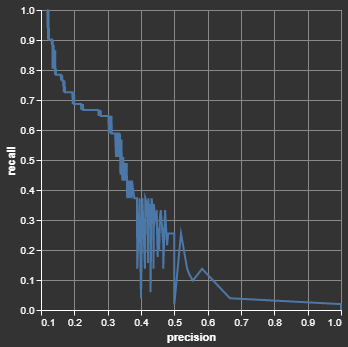

In [28]:
pr_curve( precision, recall)

In [29]:
fpr, tpr, thresholds = roc_curve( y_test, random_search.decision_function( X_test))

In [30]:
def func_roc_curve( fpr, tpr):
    plot_df = pd.DataFrame( {
        'fpr': fpr,
        'tpr': tpr
    })

    chart = alt.Chart( plot_df).mark_point().encode(
        x = 'fpr',
        y = 'tpr'
    ).properties( height = 300, width = 300)
    return chart

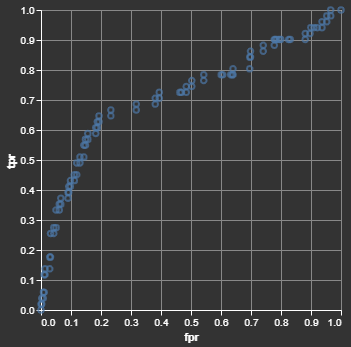

In [31]:
func_roc_curve( fpr, tpr)

## Random Forest (Let's give it a try :))

In [32]:
from sklearn.ensemble import RandomForestClassifier
pipe_rfc = make_pipeline( column_transformer, RandomForestClassifier( class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_rfc, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'RFC'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'RFC']

,mean,std
fit_time,0.194645,0.015059
score_time,0.028619,0.002619
test_precision,0.833333,0.288675
train_precision,1.000000,0.000000
test_recall,0.330909,0.199441
train_recall,1.000000,0.000000
test_f1,0.457391,0.229285
train_f1,1.000000,0.000000


In [33]:
param_dist = {
    'randomforestclassifier__n_estimators': [ 100*x for x in range( 1, 11)],
    'randomforestclassifier__max_depth': [ 10*x for x in range( 1, 11)],
    'randomforestclassifier__max_features': [ 'sqrt', 'log2'],
    'randomforestclassifier__criterion': [ 'gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [ True, False]
}

random_search = RandomizedSearchCV(
    pipe_rfc, param_dist, n_iter = 30, cv = 5, scoring = 'recall', n_jobs=-1, return_train_score = True, random_state = 918
)

random_search.fit( X_train, y_train)

results = pd.DataFrame(random_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

,params,mean_test_score
15,"{'randomforestclassifier__n_estimators': 400, ...",0.410909
4,"{'randomforestclassifier__n_estimators': 400, ...",0.410909
12,"{'randomforestclassifier__n_estimators': 300, ...",0.410909
7,"{'randomforestclassifier__n_estimators': 500, ...",0.410909
18,"{'randomforestclassifier__n_estimators': 900, ...",0.410909


In [34]:
print( results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0])

{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 90, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}


In [35]:
pipe_rfc_opt = make_pipeline( column_transformer,
                              RandomForestClassifier( n_estimators = 400, max_features = 'sqrt', max_depth = 90, criterion = 'entropy',
                                                      bootstrap = False, class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_rfc_opt, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'RFC_opt'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'RFC_opt']

,mean,std
fit_time,0.598463,0.132745
score_time,0.049026,0.010200
test_precision,0.716667,0.280129
train_precision,1.000000,0.000000
test_recall,0.410909,0.159985
train_recall,1.000000,0.000000
test_f1,0.514472,0.190103
train_f1,1.000000,0.000000


In [36]:
y_hat = random_search.predict( X_test)
test_results[ 'RFC_opt'] = better_metrics( y_test, y_hat)
print( better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print()
print( classification_report( y_test, y_hat))

         Predicted    
                 0   1
Actual 0       372   6
       1        31  20

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       378
           1       0.77      0.39      0.52        51

    accuracy                           0.91       429
   macro avg       0.85      0.69      0.74       429
weighted avg       0.90      0.91      0.90       429



In [37]:
precision, recall, thresholds = precision_recall_curve( y_test, random_search.predict_proba( X_test)[:,1])

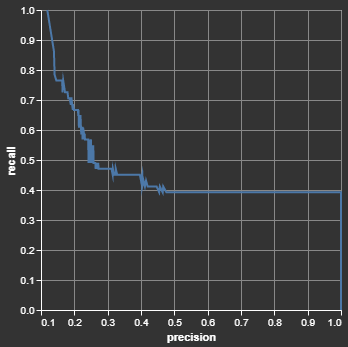

In [38]:
pr_curve( precision, recall)

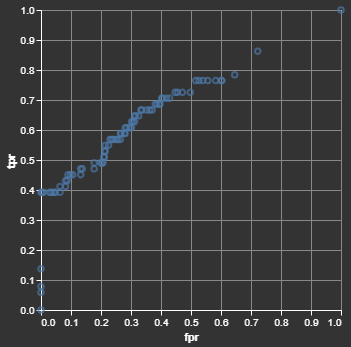

In [39]:
fpr, tpr, thresholds = roc_curve( y_test, random_search.predict_proba( X_test)[:,1])
func_roc_curve( fpr, tpr)

## Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

pipe_nb = make_pipeline( column_transformer, GaussianNB())
cv_result = cross_validate( pipe_nb, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'GaussianNB'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'GaussianNB']

,mean,std
fit_time,0.015881,0.001541
score_time,0.009800,0.001642
test_precision,0.637143,0.255870
train_precision,0.683713,0.044721
test_recall,0.389091,0.223921
train_recall,0.445854,0.050530
test_f1,0.448011,0.186705
train_f1,0.537164,0.031000


In [41]:
pipe_nb.fit( X_train, y_train) # As no hyperparameter optimization for Gaussian naive Bayes
y_hat = pipe_nb.predict( X_test)
test_results[ 'GaussianNB'] = better_metrics( y_test, y_hat)
print( better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print()
print( classification_report( y_test, y_hat))

         Predicted    
                 0   1
Actual 0       369   9
       1        28  23

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       378
           1       0.72      0.45      0.55        51

    accuracy                           0.91       429
   macro avg       0.82      0.71      0.75       429
weighted avg       0.90      0.91      0.90       429



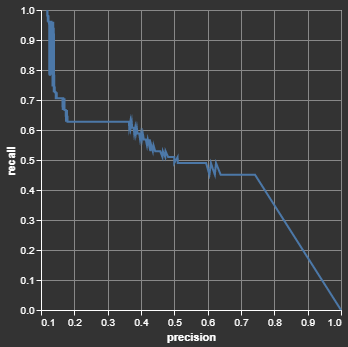

In [42]:
precision, recall, thresholds = precision_recall_curve( y_test, pipe_nb.predict_proba( X_test)[:,1])
pr_curve( precision, recall)

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 1000, solver = 'saga', class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'LogReg'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'LogReg']

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean,std
fit_time,0.140047,0.065983
score_time,0.009200,0.009934
test_precision,0.334590,0.069544
train_precision,0.368846,0.050524
test_recall,0.681818,0.194978
train_recall,0.745000,0.033599
test_f1,0.443055,0.096582
train_f1,0.492254,0.051243


In [44]:
param_dist = {
    'logisticregression__C': [ 10**x for x in range( -2, 5)],
    'logisticregression__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
    'logisticregression__l1_ratio': [ 0, 0.5, 1]
}

grid_search = GridSearchCV(
    pipe_logreg, param_dist, cv = 5, scoring = 'precision', n_jobs=-1, return_train_score = True
)

grid_search.fit( X_train, y_train)

results = pd.DataFrame( grid_search.cv_results_)
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).head()

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,params,mean_test_score
31,"{'logisticregression__C': 1, 'logisticregressi...",0.342924
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.342251
61,"{'logisticregression__C': 1000, 'logisticregre...",0.342251
60,"{'logisticregression__C': 1000, 'logisticregre...",0.342251
59,"{'logisticregression__C': 100, 'logisticregres...",0.342251


In [45]:
results[ ['params', 'mean_test_score']].sort_values( 'mean_test_score', ascending = False).iloc[ 0, 0]

{'logisticregression__C': 1,
 'logisticregression__l1_ratio': 0.5,
 'logisticregression__penalty': 'elasticnet'}

In [46]:
pipe_logreg = make_pipeline( column_transformer, LogisticRegression( max_iter = 1000, solver = 'saga', class_weight = 'balanced', random_state = 123))
cv_result = cross_validate( pipe_logreg, X_train, y_train, cv = 5, return_train_score = True, scoring = scoring_metrics)
result_dict[ 'LogReg_opt'] = pd.DataFrame( cv_result).agg( [ 'mean', 'std']).T
result_dict[ 'LogReg_opt']

C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\User\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean,std
fit_time,0.094004,0.024651
score_time,0.010142,0.003096
test_precision,0.334590,0.069544
train_precision,0.368846,0.050524
test_recall,0.681818,0.194978
train_recall,0.745000,0.033599
test_f1,0.443055,0.096582
train_f1,0.492254,0.051243


In [47]:
y_hat = grid_search.predict( X_test)
test_results[ 'LogReg_opt'] = better_metrics( y_test, y_hat)
print( better_confusion_matrix( y_test, y_hat, labels = [ 0, 1]))
print()
print( classification_report( y_test, y_hat))

         Predicted    
                 0   1
Actual 0       290  88
       1        22  29

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       378
           1       0.25      0.57      0.35        51

    accuracy                           0.74       429
   macro avg       0.59      0.67      0.59       429
weighted avg       0.85      0.74      0.78       429



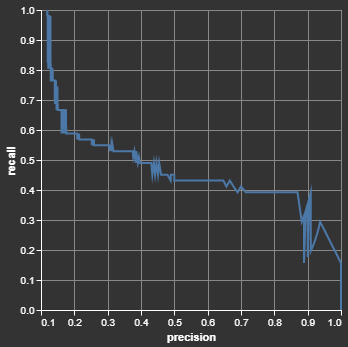

In [48]:
precision, recall, thresholds = precision_recall_curve( y_test, grid_search.predict_proba( X_test)[:,1])
pr_curve( precision, recall)

## Overall

In [49]:
overall = pd.concat( result_dict, axis = 1)
overall

KNN             KNN_opt                 SVC            \
                     mean       std      mean       std      mean       std   
fit_time         0.013790  0.004319  0.017916  0.007627  0.010615  0.008644   
score_time       0.052255  0.071590  0.017277  0.005906  0.013466  0.003457   
test_precision   0.340000  0.421900  0.340000  0.421900  0.379286  0.086058   
train_precision  0.706984  0.150416  0.706984  0.150416  0.600542  0.148967   
test_recall      0.058182  0.053242  0.058182  0.053242  0.527273  0.196771   
train_recall     0.171463  0.072884  0.171463  0.072884  0.779268  0.046518   
test_f1          0.093800  0.087339  0.093800  0.087339  0.436559  0.115877   
train_f1         0.272490  0.097502  0.272490  0.097502  0.669204  0.086089   

                  SVC_opt                 RFC             RFC_opt            \
                     mean       std      mean       std      mean       std   
fit_time         0.022798  0.004392  0.194645  0.015059  0.598463  0.132745   
score_time       0.014411  0.002620  0.028619  0.002619  0.049026  0.010200   
test_precision   0.162378  0.028493  0.833333  0.288675  0.716667  0.280129   
train_precision  0.181736  0.005795  1.000000  0.000000  1.000000  0.000000   
test_recall      0.900000  0.100000  0.330909  0.199441  0.410909  0.159985   
train_recall     0.936341  0.013032  1.000000  0.000000  1.000000  0.000000   
test_f1          0.274952  0.045373  0.457391  0.229285  0.514472  0.190103   
train_f1         0.304340  0.007832  1.000000  0.000000  1.000000  0.000000   

                GaussianNB              LogReg           LogReg_opt            
                      mean       std      mean       std       mean       std  
fit_time          0.015881  0.001541  0.140047  0.065983   0.094004  0.024651  
score_time        0.009800  0.001642  0.009200  0.009934   0.010142  0.003096  
test_precision    0.637143  0.255870  0.334590  0.069544   0.334590  0.069544  
train_precision   0.683713  0.044721  0.368846  0.050524   0.368846  0.050524  
test_recall       0.389091  0.223921  0.681818  0.194978   0.681818  0.194978  
train_recall      0.445854  0.050530  0.745000  0.033599   0.745000  0.033599  
test_f1           0.448011  0.186705  0.443055  0.096582   0.443055  0.096582  
train_f1          0.537164  0.031000  0.492254  0.051243   0.492254  0.051243

In [50]:
overall_mean = overall.T.xs( 'mean', level = 1).T # Probably not the most elegant way to do that.
overall_mean

,KNN,KNN_opt,SVC,SVC_opt,RFC,RFC_opt,GaussianNB,LogReg,LogReg_opt
fit_time,0.013790,0.017916,0.010615,0.022798,0.194645,0.598463,0.015881,0.140047,0.094004
score_time,0.052255,0.017277,0.013466,0.014411,0.028619,0.049026,0.009800,0.009200,0.010142
test_precision,0.340000,0.340000,0.379286,0.162378,0.833333,0.716667,0.637143,0.334590,0.334590
train_precision,0.706984,0.706984,0.600542,0.181736,1.000000,1.000000,0.683713,0.368846,0.368846
test_recall,0.058182,0.058182,0.527273,0.900000,0.330909,0.410909,0.389091,0.681818,0.681818
train_recall,0.171463,0.171463,0.779268,0.936341,1.000000,1.000000,0.445854,0.745000,0.745000
test_f1,0.093800,0.093800,0.436559,0.274952,0.457391,0.514472,0.448011,0.443055,0.443055
train_f1,0.272490,0.272490,0.669204,0.304340,1.000000,1.000000,0.537164,0.492254,0.492254


In [51]:
pd.DataFrame( test_results)

,KNN_opt,SVC_opt,RFC_opt,GaussianNB,LogReg_opt
precision,0.615385,0.141869,0.769231,0.718750,0.247863
recall,0.156863,0.803922,0.392157,0.450980,0.568627
f1,0.250000,0.241176,0.519481,0.554217,0.345238
auc,0.571818,0.573918,0.688142,0.713585,0.667912
